# 0 Set up

Notes for Jacopo:


*   Cosa possiamo dire dell'evoluzione dell'IAT
*   Cosa possiamo dire dell'alterazione dell'IAT, all'incontro con un commento tossico.
Analizziamo per ogni utente in un thread, come  l'interarrival time tende a incrementare e se è legato a qualcosa che accade nell'intorno.




<br>
This EDAA  is for Walter, in order to find togheter a mattern or a signal that needs to be investigated<br>


In [ ]:
kernel='j'

In [ ]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/EDA'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from EDA_package.function import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 494, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 494 (delta 103), reused 53 (delta 22), pack-reused 320
Receiving objects: 100% (494/494), 28.28 MiB | 14.63 MiB/s, done.
Resolving deltas: 100% (233/233), done.
Mounted at /content/drive


In [ ]:
import sys
import os
import numpy as np
module_path = '/Users/jacoponudo/Documents/thesis/src/EDA'
sys.path.append(module_path)
from EDA_package.function import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

# 1 Interazione


## 1.1 Inter Arrival Time (IAT)

*Escludiamo le interazione con meno di 3 commenti, calcoliamo la posizione rispetto all'inizio e la fine della conversazione ∈ [0,1]*

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>3].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

*L'IAT non è omogeneo nella conversazone.
Notiamo che l'inter arrival time tende a crescere nella fase finale della conversazione, l'utente si stufa, risponde sempre meno prontamente, fino a uscire.*

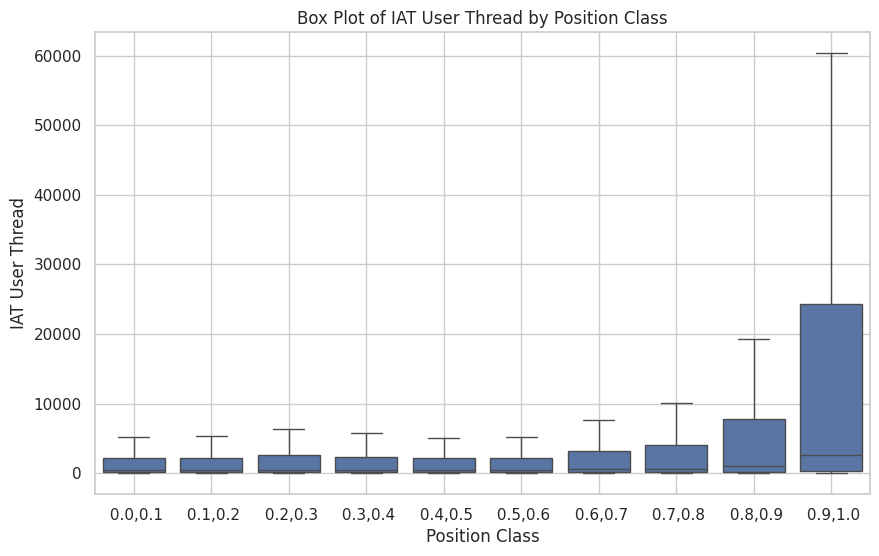

In [ ]:
number_of_classes=10
data['position_class'] = pd.cut(data['position_user_thread'], bins=number_of_classes, labels=False)

plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='IAT_user_thread', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()

## 1.2 La dilatazione finale smussa la tossicità

*Osserviamo come se la fase finale della conversazione risulta piu rilassata, con ritmi piu flebili, la conversazione tende ad essere meno tossica.*


<ipython-input-168-ef8206485fc2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=True, palette='Set1')


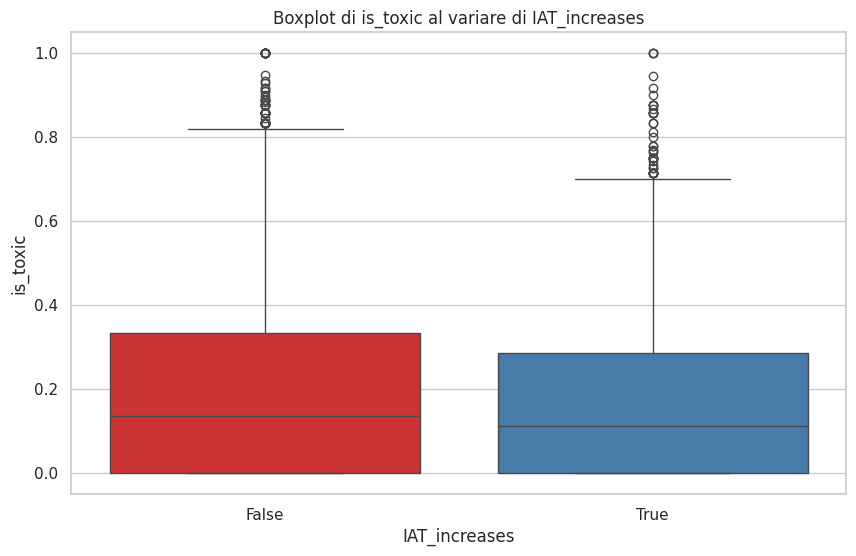

Test t di Student:
Statistiche t: 2.8280866870376293
Valore p: 0.004694994072955063


In [ ]:
# Trova l'IAT mediana e finale di ogni conversazione per ogni utente
mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))


data['is_toxic']=data['toxicity_score']>0.6
toxicity=data.groupby(['user','root_submission'])['is_toxic'].mean()

merged_df=merged_df.merge(toxicity,on=['user', 'root_submission'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=True, palette='Set1')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()

means = merged_df.groupby('IAT_increases')['is_toxic'].mean()
t_statistic, p_value = stats.ttest_ind(merged_df.loc[merged_df['IAT_increases'] == 0, 'is_toxic'],
                                       merged_df.loc[merged_df['IAT_increases'] == 1, 'is_toxic'])

print("Test t di Student:")
print("Statistiche t:", t_statistic)
print("Valore p:", p_value)

## 1.3 Ritmo della conversazione e ritmo dell'utente

Se l'inter return time dell'utente segue il flusso della conversazione tende ad essere piu tossico, mentre se dilatato nel tempo tende a esserlo meno.

<ipython-input-425-93f0650c34ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_toxic']=df['toxicity_score']>0.6


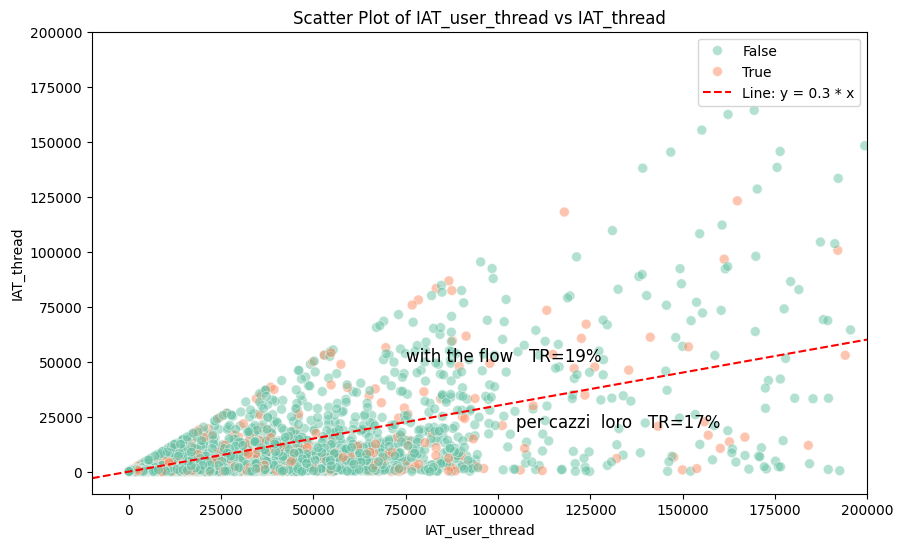

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
df = data.dropna(subset=['IAT_user_thread', 'IAT_thread'])
df['is_toxic']=df['toxicity_score']>0.6


import seaborn as sns
import matplotlib.pyplot as plt

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IAT_user_thread', y='IAT_thread', hue='is_toxic', data=df, s=50, alpha=0.5, palette='Set2')
plt.title('Scatter Plot of IAT_user_thread vs IAT_thread')
plt.xlabel('IAT_user_thread')
plt.ylabel('IAT_thread')
plt.xlim(-10000, 200000)
plt.ylim(-10000, 200000)
plt.legend(title='Is Toxic')

# Plot the line
x_values = np.linspace(-10000, 200000, 100)
y_values = 0.3 * x_values
plt.plot(x_values, y_values, color='red', linestyle='--', label='Line: y = 0.3 * x')
plt.text(75000, 50000, 'with the flow   TR=19%', fontsize=12, color='black')
plt.text(105000, 20000, 'per cazzi  loro   TR=17%', fontsize=12, color='black')

plt.legend()

plt.show()




<ipython-input-413-604c798975ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['with_the_flow']=(df['IAT_thread']/(df['IAT_user_thread']+0.00000001))>0.3


il dataset è diviso in 0.537639405204461


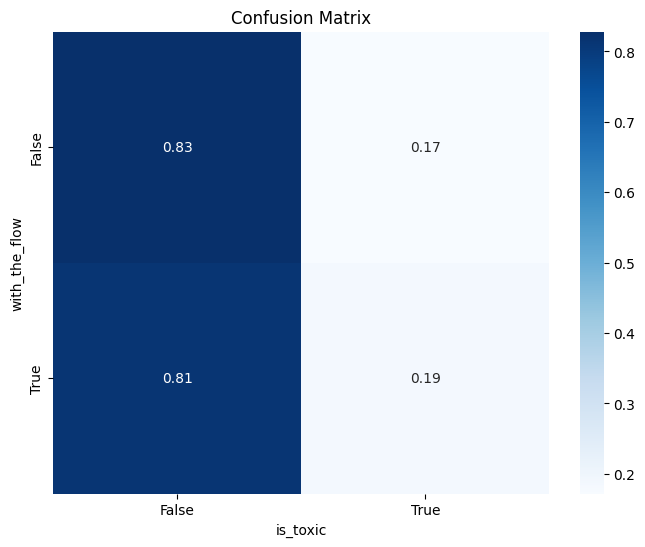


Chi-square Test - Chi2: 4.942654165069275, p-value: 0.026201772280128145


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['with_the_flow']=(df['IAT_thread']/(df['IAT_user_thread']+0.00000001))>0.3

print('il dataset è diviso in', (df['with_the_flow'].mean()))
conf_matrix = confusion_matrix(df['with_the_flow'], df['is_toxic'])
conf_df = pd.DataFrame(conf_matrix)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_df_norm = pd.DataFrame(conf_matrix_norm,index=['False', 'True'], columns=['False', 'True'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('with_the_flow')
plt.xlabel('is_toxic')
plt.show()
chi2, p, _, _ = chi2_contingency(conf_matrix)
print(f"\nChi-square Test - Chi2: {chi2}, p-value: {p}")


# 2 Tossicità

## 2.1 Velocità e Tossicità

Preso un utente in una conversazione, la tossicità non sembra velocizzare i suoi tempi di ritposta.

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>4].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

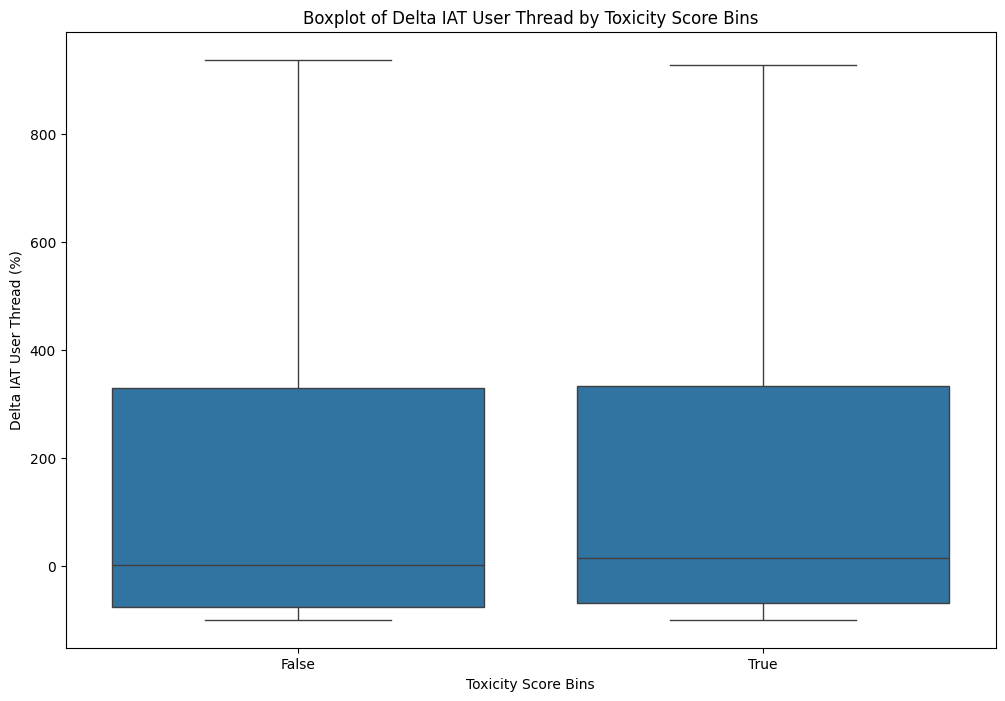

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convertiamo la colonna 'created_at' in datetime per un ordinamento corretto
df['created_at'] = pd.to_datetime(df['created_at'])
df['is_toxic'] =df['toxicity_score']>0.6

# Ordiniamo il DataFrame
df_sorted = df.sort_values(by=['user', 'root_submission', 'created_at'])

# Calcola la variazione percentuale di IAT_user_thread tra la riga corrente e quella precedente
df_sorted['delta_IAT_user_thread'] = df_sorted['IAT_user_thread'].pct_change() * 100

# Filtriamo solo le colonne necessarie
df_filtered = df_sorted[['delta_IAT_user_thread', 'is_toxic', 'sequential_number_of_comment_by_user_in_thread']]

# Creiamo i boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='is_toxic', y='delta_IAT_user_thread', data=df_filtered,showfliers=False)
plt.xlabel('Toxicity Score Bins')
plt.ylabel('Delta IAT User Thread (%)')
plt.title('Boxplot of Delta IAT User Thread by Toxicity Score Bins')
plt.show()


## 2.2 Toxicità nell'intorno

Analizziamo se un commento tossico, nel suo intorno è circondato da commenti tossici. I seguenti risultati sono ottenuti usando un intorno di raggio 2. Mostrano che esiste una correlazione tra il livello di tossicità e l'intorno temporale di una conversazione.
Questo però non tiene conto che in alcune piattaforme le conversazioni si ramificano.

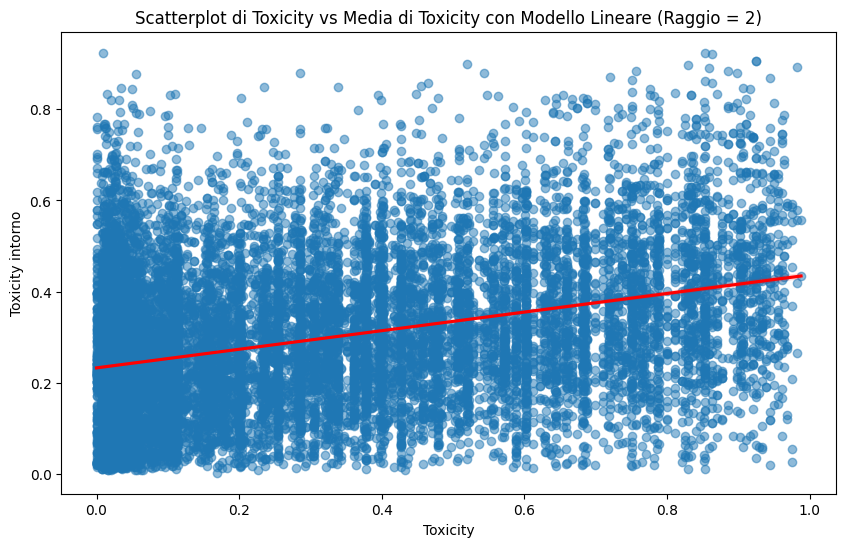

                            OLS Regression Results                            
Dep. Variable:       Toxicity intorno   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1988.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        13:51:58   Log-Likelihood:                 4377.6
No. Observations:               16140   AIC:                            -8751.
Df Residuals:                   16138   BIC:                            -8736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2248      0.002    106.857      0.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm

# Supponiamo che data_sorted sia già definito e ordinato

# Raggi da considerare
radii = [2, 3, 4, 5, 10,15,20]

# Lista per memorizzare tutti i risultati
all_results = []
model_summaries = {}

for r in radii:
    x = []
    y = []

    # Iterazione sul DataFrame data_sorted
    for i, row in tqdm(data_sorted.iterrows(), total=len(data_sorted)):
        tox = row['toxicity_score']
        created_at = row['created_at']

        df = data_sorted[data_sorted['root_submission'] == row['root_submission']].reset_index()

        idx = (df['created_at'] == created_at).idxmax()
        mean_tox = np.mean(df.loc[max(0, idx - r):min(len(df) - 1, idx + r), 'toxicity_score'].drop(idx))

        # Aggiungi i valori a x e y solo se non sono NaN o non numerici
        if pd.notna(mean_tox) and np.isfinite(mean_tox):
            x.append(tox)
            y.append(mean_tox)

    # Creazione del DataFrame per il raggio corrente e aggiunta della colonna Radius
    scatter_df = pd.DataFrame({'Toxicity': x, 'Toxicity intorno': y})
    scatter_df['Radius'] = r

    # Aggiunta del DataFrame alla lista di tutti i risultati
    all_results.append(scatter_df)

    # Creazione del modello di regressione lineare
    X = sm.add_constant(scatter_df['Toxicity'])
    model = sm.OLS(scatter_df['Toxicity intorno'], X).fit()
    model_summaries[r] = model.summary()

# Concatenazione di tutti i DataFrame in uno solo
final_results = pd.concat(all_results, ignore_index=True)

# Salvataggio del DataFrame finale su disco (opzionale)
final_results.to_csv('toxicity_results.csv', index=False)

# Visualizzazione del modello per il raggio 2
df = final_results[final_results['Radius'] == 10]
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di Toxicity vs Media di Toxicity con Modello Lineare (Raggio = 2)')
plt.xlabel('Toxicity')
plt.ylabel('Toxicity intorno')
plt.show()

# Stampa del sommario del modello per il raggio 2
print(model_summaries[2])


# 3 Propagazione Tossicità

La tossicità si propagatra utenti che sono connessi temporalemnte?

## 3.1 Grafo

In [ ]:
import pandas as pd
from itertools import combinations
import pandas as pd
import networkx as nx
data['root_submission'].value_counts().reset_index()
data['created_at'] = pd.to_datetime(data['created_at'])

data = data.dropna(subset=['user'])

thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


users=thread.user.dropna().unique()

user_pairs = list(combinations(users, 2))

edge_weights = []

# Calcolo dei pesi per le coppie di utenti
for pair in tqdm(user_pairs):
    user1_dates = thread[thread['user'] == pair[0]]['created_at']
    user2_dates = thread[thread['user'] == pair[1]]['created_at']

    if not user1_dates.empty and not user2_dates.empty:
        distances_1_2 = [min(abs(date1 - date2).total_seconds() for date2 in user2_dates) for date1 in user1_dates]
        distances_2_1 = [min(abs(date2 - date1).total_seconds() for date1 in user1_dates) for date2 in user2_dates]
        distances=(np.max(distances_1_2)+np.max(distances_2_1))/2

        # Numero totale di messaggi scambiati tra i due utenti
        total_messages = len(user1_dates) + len(user2_dates) - 1

        # Calcolo del peso come funzione della vicinanza temporale e del numero di messaggi
        w = ((total_messages) ** 3) * (1 / distances if distances else 0)
        # Aggiunta dei pesi alla lista
        edge_weights.append((pair[0], pair[1], w))
        edge_weights.append((pair[1], pair[0], w))

edge_weights_df = pd.DataFrame(edge_weights, columns=['source', 'target', 'weight'])

print("DataFrame dei pesi degli archi:")
print(edge_weights_df)

100%|██████████| 378/378 [00:00<00:00, 664.87it/s]

DataFrame dei pesi degli archi:
             source          target    weight
0         GoatSLAVE     6double5321  0.003715
1       6double5321       GoatSLAVE  0.003715
2         GoatSLAVE  Amateur_Wizard  0.003715
3    Amateur_Wizard       GoatSLAVE  0.003715
4         GoatSLAVE      Crashmarik  0.003715
..              ...             ...       ...
751           Bhig3         artsy10  0.000091
752         artsy10        nice_tie  0.000031
753        nice_tie         artsy10  0.000031
754           Bhig3        nice_tie  0.000046
755        nice_tie           Bhig3  0.000046

[756 rows x 3 columns]


In [ ]:
# Create the graph
G = nx.Graph()
for _, row in edge_weights_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    G.add_edge(source, target, weight=weight)



In [ ]:
# Add toxicity value to each user
max_toxicity_scores = thread.groupby(['user'])['toxicity_score'].max().reset_index()
max_toxicity_scores_dict = dict(zip(max_toxicity_scores['user'], max_toxicity_scores['toxicity_score']))
for node in G.nodes():
    if node in max_toxicity_scores_dict:
        G.nodes[node]['max_toxicity_score'] = max_toxicity_scores_dict[node]>0.5
    else:
        G.nodes[node]['max_toxicity_score'] = None

In [ ]:

# Prune Network
edge_weights = [weight for _, _, weight in G.edges(data='weight')]

weight_threshold = np.percentile(edge_weights, 95)

pruned_G = G.copy()
for edge in G.edges():
    source, target = edge
    weight = G.edges[edge]['weight']
    if weight < weight_threshold:
        pruned_G.remove_edge(source, target)

<ipython-input-335-3f7be2509b2c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


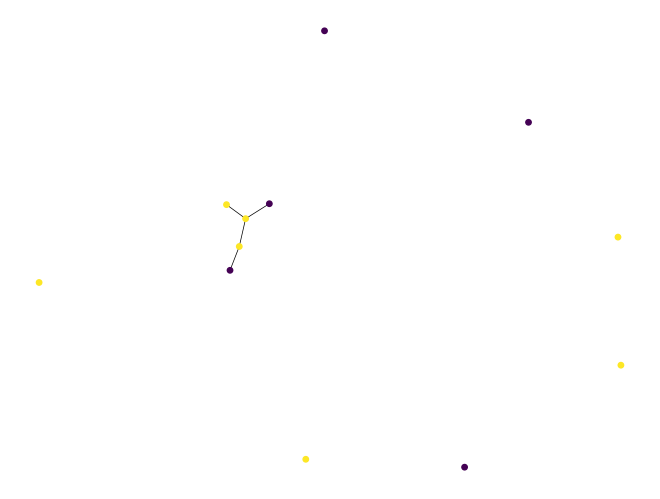

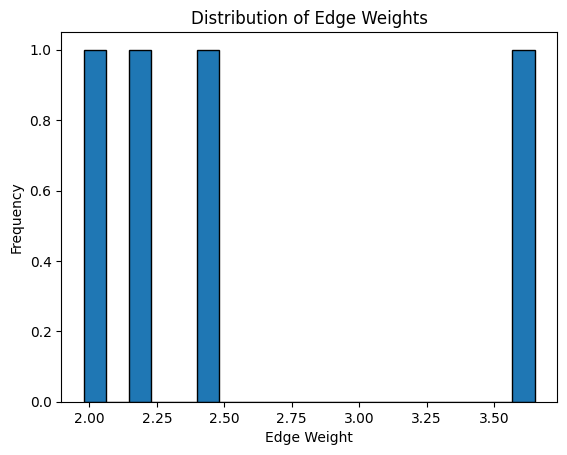

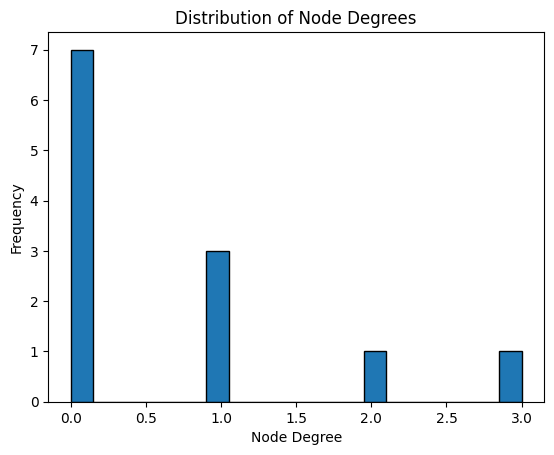

In [ ]:
# Visualize Graph
cmap = plt.cm.get_cmap('viridis')
max_toxicity_scores = [G.nodes[node]['max_toxicity_score'] for node in G.nodes()]
norm = plt.Normalize(vmin=min(max_toxicity_scores), vmax=max(max_toxicity_scores))
node_colors = [cmap(norm(score)) if score is not None else 'gray' for score in max_toxicity_scores]
nx.draw(pruned_G, with_labels=False, node_size=15, width=0.52, node_color=node_colors)
plt.show()

# Distribution of edge weights
edge_weights = [pruned_G.edges[edge]['weight'] for edge in pruned_G.edges()]
plt.hist(edge_weights, bins=20, edgecolor='black')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights')
plt.show()

# Distribution of node degrees
node_degrees = [degree for _, degree in pruned_G.degree()]
plt.hist(node_degrees, bins=20, edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Node Degrees')
plt.show()



In [ ]:
max_weight_edge = max(pruned_G.edges(data=True), key=lambda x: x[2]['weight'])

print("L'arco più forte è:", max_weight_edge)

L'arco più forte è: ('collator', 'Culture_shift', {'weight': 3.651234052036325})


<ipython-input-337-df6ff3298acf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])


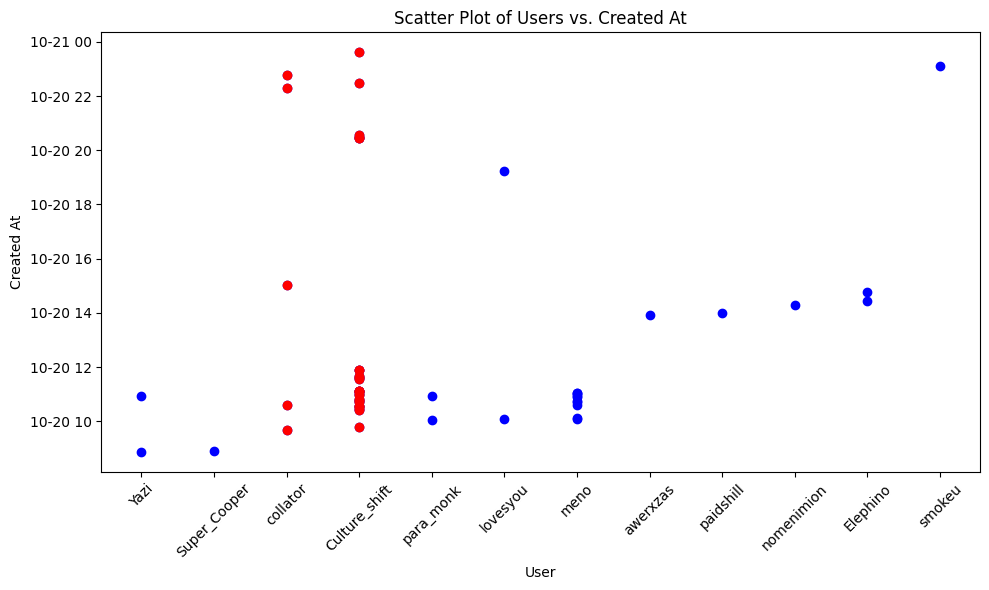

In [ ]:
# Convertire la colonna 'created_at' in datetime

df=thread[(thread['user']==max_weight_edge[0]) | (thread['user']==max_weight_edge[1])]

df['created_at'] = pd.to_datetime(df['created_at'])
# Creare il plot
plt.figure(figsize=(10, 6))
plt.scatter(thread['user'], thread['created_at'], c='blue', marker='o')
plt.scatter(df['user'], df['created_at'], c='red', marker='o')

# Aggiungere etichette e titolo
plt.xlabel('User')
plt.ylabel('Created At')
plt.title('Scatter Plot of Users vs. Created At')

# Ruotare le etichette dell'asse X per una migliore leggibilità
plt.xticks(rotation=45)

# Mostrare il plot
plt.tight_layout()
plt.show()


In [ ]:
# Dato un utente, tossico o no, tra i suo amici c'è un tossico?
x_values=[]
y_values=[]

for node in pruned_G.nodes():
    max_toxicity_score = pruned_G.nodes[node]['max_toxicity_score']

    neighbors = list(pruned_G.neighbors(node))
    weights = [pruned_G[node][neighbor].get('weight', 1) for neighbor in pruned_G.neighbors(node)]
    normalized_weights = [(weight - min(weights)) / (max(weights) - min(weights)) if max(weights) != min(weights) else 1 for weight in weights] if weights else []


    if neighbors:
        toxicity_scores_neighbors = [pruned_G.nodes[neighbor].get('max_toxicity_score', 0) for neighbor in neighbors]
        numeric_list = [1 if value else 0 for value in toxicity_scores_neighbors]
        median_toxicity_score_neighbors = np.mean([a * b for a, b in zip(normalized_weights, toxicity_scores_neighbors)])
    else:
        median_toxicity_score_neighbors = 0

    x_values.append(max_toxicity_score)
    y_values.append(median_toxicity_score_neighbors)

df = pd.DataFrame({'x': x_values, 'y': y_values})
df=df.dropna()



tossico: 0.2619047619047619
non tossico: 0.4


<Figure size 1000x600 with 0 Axes>

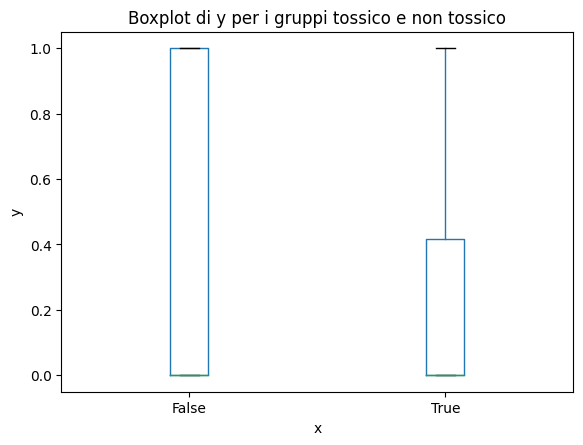

T-statistic: -0.5170005810573411
P-value: 0.6163966610539432


In [ ]:

if isinstance(df['x'][0], bool):
    # Creiamo lo scatterplot
  plt.figure(figsize=(10, 6))
  plt.scatter(df['x'], df['y'])
  plt.title('Scatterplot di x e y')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
else:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.stats import ttest_ind

  # Supponiamo che il DataFrame df sia già caricato

  # Calcolare le medie dei valori di 'y' per i gruppi definiti da 'x'
  mean_tossico = np.mean(df[df['x']]['y'])
  mean_non_tossico = np.mean(df[~df['x']]['y'])

  print('tossico:', mean_tossico)
  print('non tossico:', mean_non_tossico)

  # Stampare i boxplot dei due gruppi
  plt.figure(figsize=(10, 6))
  df.boxplot(column='y', by='x', grid=False)
  plt.title('Boxplot di y per i gruppi tossico e non tossico')
  plt.suptitle('')  # Rimuove il titolo automatico generato da pandas
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  # Eseguire un test di indipendenza (t-test) tra i due gruppi
  group_tossico = df[df['x']]['y']
  group_non_tossico = df[~df['x']]['y']

  t_stat, p_value = ttest_ind(group_tossico, group_non_tossico)

  print('T-statistic:', t_stat)
  print('P-value:', p_value)


## 3.2 Procedure for all threads

In [ ]:
import pandas as pd
from itertools import combinations
import pandas as pd
import networkx as nx
import time
data['root_submission'].value_counts().reset_index()
data['created_at'] = pd.to_datetime(data['created_at'])
time_limit = 60

data = data.dropna(subset=['user'])
dataframes = []
for i in tqdm(range(1000)):
  start_time = time.time()
  thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


  users=thread.user.dropna().unique()

  user_pairs = list(combinations(users, 2))

  edge_weights = []

  # Calcolo dei pesi per le coppie di utenti
  for pair in (user_pairs):
      end_time = time.time()  # End timing the iteration
      if end_time - start_time > time_limit:  # Check if the iteration took longer than the time limit
          print(f"Iteration {i} took longer than {time_limit} seconds. Skipping to next iteration.")
          break
      user1_dates = thread[thread['user'] == pair[0]]['created_at']
      user2_dates = thread[thread['user'] == pair[1]]['created_at']

      if not user1_dates.empty and not user2_dates.empty:
          distances_1_2 = [min(abs(date1 - date2).total_seconds() for date2 in user2_dates) for date1 in user1_dates]
          distances_2_1 = [min(abs(date2 - date1).total_seconds() for date1 in user1_dates) for date2 in user2_dates]
          distances=(np.max(distances_1_2)+np.max(distances_2_1))/2

          total_messages = len(user1_dates) + len(user2_dates) - 1

          w = ((total_messages) ** 3) * (1 / distances if distances else 0)

          edge_weights.append((pair[0], pair[1], w))
          edge_weights.append((pair[1], pair[0], w))

  edge_weights_df = pd.DataFrame(edge_weights, columns=['source', 'target', 'weight'])

  # Create the graph
  G = nx.Graph()
  for _, row in edge_weights_df.iterrows():
      source = row['source']
      target = row['target']
      weight = row['weight']
      G.add_edge(source, target, weight=weight)


  # Add toxicity value to each user
  max_toxicity_scores = thread.groupby(['user'])['toxicity_score'].max().reset_index()
  max_toxicity_scores_dict = dict(zip(max_toxicity_scores['user'], max_toxicity_scores['toxicity_score']))
  for node in G.nodes():
      if node in max_toxicity_scores_dict:
          G.nodes[node]['max_toxicity_score'] = max_toxicity_scores_dict[node]
      else:
          G.nodes[node]['max_toxicity_score'] = 0
  # Prune Network
  edge_weights = [weight for _, _, weight in G.edges(data='weight')]

  weight_threshold = np.percentile(edge_weights, 95)

  pruned_G = G.copy()
  for edge in G.edges():
      source, target = edge
      weight = G.edges[edge]['weight']
      if weight < weight_threshold:
          pruned_G.remove_edge(source, target)
  # Dato un utente, tossico o no, tra i suo amici c'è un tossico?
  x_values=[]
  y_values=[]

  for node in pruned_G.nodes():
      max_toxicity_score = pruned_G.nodes[node]['max_toxicity_score']

      neighbors = list(pruned_G.neighbors(node))
      weights = [pruned_G[node][neighbor].get('weight', 1) for neighbor in pruned_G.neighbors(node)]
      normalized_weights = [(weight - min(weights)) / (max(weights) - min(weights)) if max(weights) != min(weights) else 1 for weight in weights] if weights else []


      if neighbors:
          toxicity_scores_neighbors = [pruned_G.nodes[neighbor].get('max_toxicity_score', 0) for neighbor in neighbors]
          numeric_list = [1 if value else 0 for value in toxicity_scores_neighbors]
          median_toxicity_score_neighbors = np.mean([a * b for a, b in zip(normalized_weights, toxicity_scores_neighbors)])
          median_toxicity_score_neighbors = np.max(toxicity_scores_neighbors)

      else:
          median_toxicity_score_neighbors = 0

      x_values.append(max_toxicity_score)
      y_values.append(median_toxicity_score_neighbors)

  df = pd.DataFrame({'x': x_values, 'y': y_values})
  dataframes.append(df)  # Aggiungi il DataFrame alla lista

  # Concatenazione di tutti i DataFrame nella lista
  final_df = pd.concat(dataframes, ignore_index=True)
  final_df.to_csv('/content/drive/MyDrive/thesis/data/x_y_toxicity_homopily.csv')

  1%|          | 7/1000 [00:40<1:35:37,  5.78s/it]


KeyboardInterrupt: 

In [ ]:
final_df.to_csv('/content/drive/MyDrive/thesis/data/x_y_toxicity_homopily.csv')

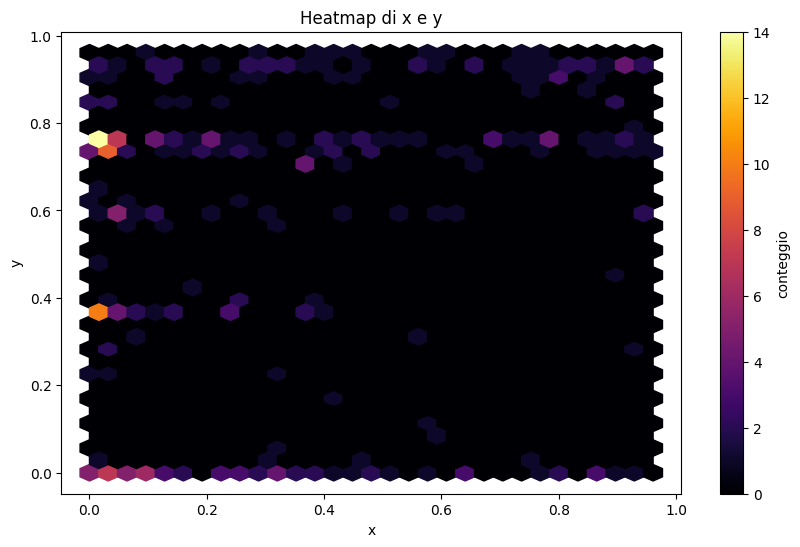

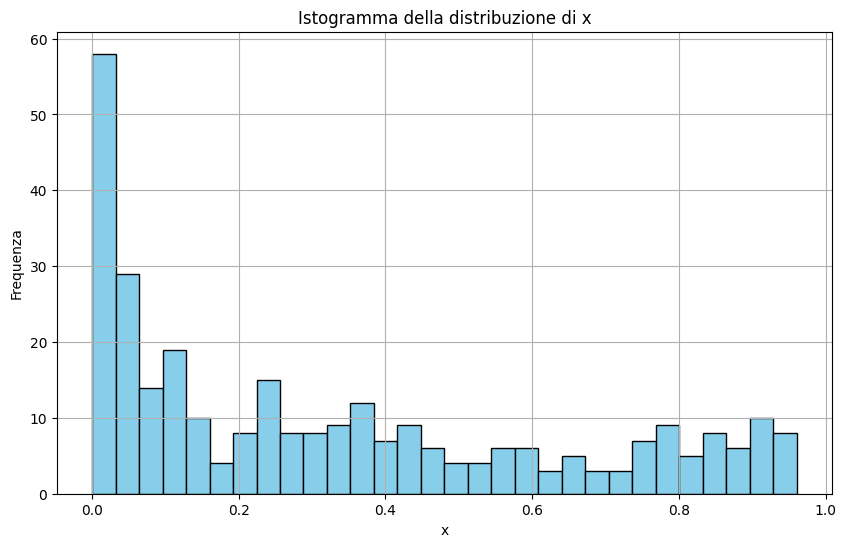

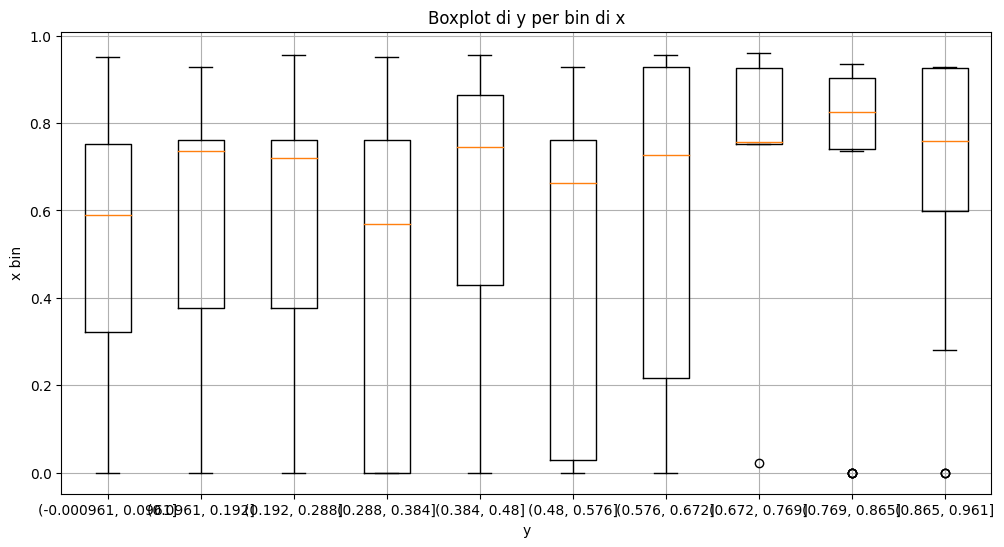

In [ ]:
df=final_df
plt.figure(figsize=(10, 6))
plt.hexbin(df['x'], df['y'], gridsize=30, cmap='inferno')
plt.colorbar(label='conteggio')
plt.title('Heatmap di x e y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


import matplotlib.pyplot as plt

# Plot dell'istogramma della distribuzione di x
plt.figure(figsize=(10, 6))
plt.hist(df['x'], bins=30, color='skyblue', edgecolor='black')
plt.title('Istogramma della distribuzione di x')
plt.xlabel('x')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()



import pandas as pd
import matplotlib.pyplot as plt

# Suddividi x in 5 bin
df['x_bin'] = pd.cut(df['x'], bins=10)

# Creare boxplot per y in base ai bin di x
plt.figure(figsize=(12, 6))
plt.title('Boxplot di y per bin di x')
plt.xlabel('y')
plt.ylabel('x bin')
plt.grid(True)
plt.boxplot([df[df['x_bin'] == bin_val]['y'] for bin_val in sorted(df['x_bin'].unique())], vert=True, labels=sorted(df['x_bin'].unique()))
plt.show()




# 4 Frequenza commento tossico

Con che frequenza arriva un messaggio tossico, questa dipende  dall'IAT dei messaggi, è omogenea nel tempoo?

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


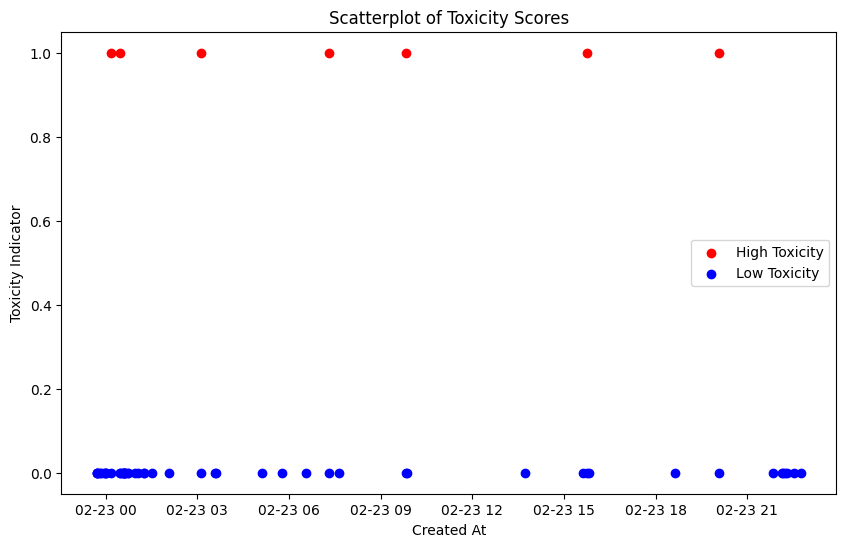

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già caricato il tuo DataFrame `thread`
# thread = pd.read_csv('path_to_your_data.csv')  # Carica i tuoi dati

# Filtra i dati basati sul punteggio di tossicità
high_toxicity = thread[thread['toxicity_score'] > 0.6]

# Crea lo scatterplot
plt.figure(figsize=(10, 6))

# Punti con alto punteggio di tossicità (1)
plt.scatter(high_toxicity['created_at'], [1] * len(high_toxicity), color='red', label='High Toxicity')

# Punti con basso punteggio di tossicità (0)
plt.scatter(thread['created_at'], [0] * len(thread), color='blue', label='Low Toxicity')

# Aggiungi etichette e titolo
plt.xlabel('Created At')
plt.ylabel('Toxicity Indicator')
plt.title('Scatterplot of Toxicity Scores')
plt.legend()

# Mostra il grafico
plt.show()


In [ ]:
import itertools

# Inizializza una lista vuota per contenere le somme cumulative
cumulative_sums = []

# Simula il tuo ciclo for con i dati di esempio
for i in range(10000):
    thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]

    dfs_successors = thread['toxicity_score'] > 0.6

    count_falses = 0
    results = []
    for value in dfs_successors:
        if value:
            results.append(count_falses)
            count_falses = 0
        else:
            count_falses += 1
    results.append(count_falses)
    if len(dfs_successors) == sum(dfs_successors):
      results_divided = results
    else:
      results_divided = [result / (len(dfs_successors) - sum(dfs_successors)) for result in results]
    cumulative_sum = list(itertools.accumulate(results_divided))
    gol_per_intervallo = [0] *5
    if len(cumulative_sum)!=1:
      for istante in cumulative_sum:
          intervallo = int(istante * 5)-1
          gol_per_intervallo[intervallo]  +=( 1/len(cumulative_sum))


    # Aggiungi la somma cumulativa a cumulative_sums
    cumulative_sums.append(gol_per_intervallo)



[1.0, 1.0]

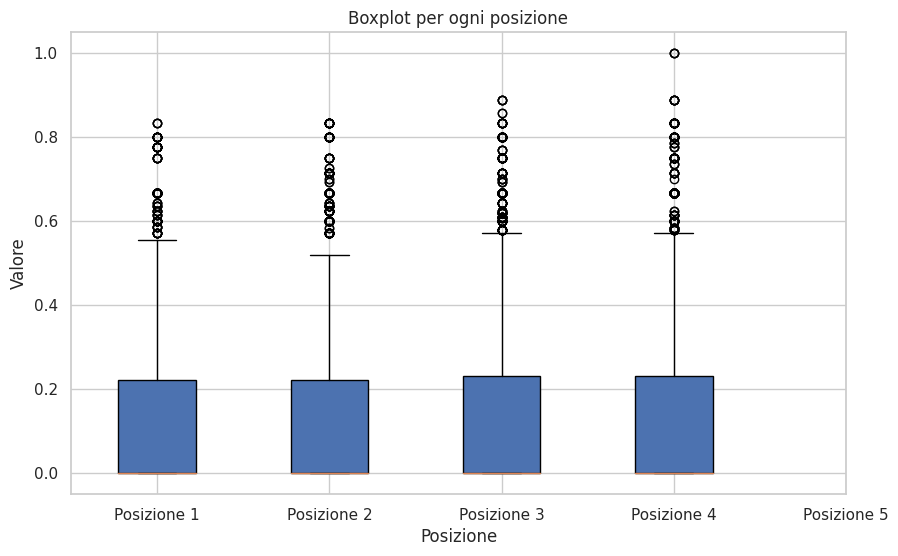

In [ ]:
# Creazione di una lista di liste per ogni posizione
valori_per_posizione = [[lista[i] for lista in cumulative_sums] for i in range(0,len(cumulative_sums[0])-1)]

# Creazione del boxplot per ogni posizione
plt.figure(figsize=(10, 6))
plt.boxplot(valori_per_posizione, patch_artist=True)
plt.xlabel('Posizione')
plt.ylabel('Valore')
plt.title('Boxplot per ogni posizione')
plt.xticks(range(1, len(cumulative_sums[0]) + 1), [f'Posizione {i + 1}' for i in range(len(cumulative_sums[0]))])
plt.grid(True)
plt.show()

# 5 Viaggio nel thread

In [ ]:

df=data
df['created_at'] = pd.to_datetime(df['created_at'])
row=df[df['sequential_number_of_comment_by_user_in_thread']==1].sample(1)


thread=df[(df['root_submission']==row['root_submission'].values[0])]

thread = thread.sort_values(by='created_at')
entrata = list(thread['user'] == row['user'].values[0]).index(True)
pre=thread[:entrata]
np.mean(pre['sequential_number_of_comment_by_user_in_thread']!=1)